# Inductive Pagerank [DEMO]

The Inductive Pagerank technique is based on the APATE technique by Van Vlasselaer et al. (2016).
This technique is an important benchmark for network-based fraud detection. Hence, performance obtained in this notebook can be compared with performance of the CATCHM technique.

Before running the demo, please download the demo dataset from Kaggle:
https://www.kaggle.com/ranjeetshrivastav/fraud-detection-dataset


In [1]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import xgboost as xgb
from fucc.metrics import plot_ap, get_optimal_f1_cutoff, get_confusion_matrix
from sklearn.metrics import average_precision_score
import logging
logging.basicConfig(level=logging.INFO)

In [2]:
from fucc.pagerank import get_pagerank_suspicion_scores, inductive_step, splitDataFrameIntoSmaller, postprocessing_historical_edges
from fucc.utils import get_filename, export_suspicion_scores, import_suspicion_scores, multiprocessing
from tqdm import tqdm
from functools import partial
import datetime
import pickle

In [3]:
# Parameters
weighted = True
lambdas = {'ST': 0.03, 'MT': 0.004, 'LT': 0.0001}
chunksize = 5000
# the 'workers' parameter is used for multi-processing.
WORKERS = 12

In [4]:
output_path = ''

## Load Data

In [5]:
### PATH TO DEMO DATA ###
demo_data_path = './transactions/transactions.txt'

df = pd.read_json(demo_data_path,  lines=True, convert_dates=[4])
# Transform fourth column to datetime format
df.iloc[:, 4] = pd.to_datetime(df.iloc[:, 4])
# Sort dataframe by datetime
df = df.sort_values('transactionDateTime')
# Create a transaction ID
df.loc[:, 'TX_ID'] = range(df.shape[0])
# Rename columns to work with hard-coded feature names in our code
df = df.rename(columns={"merchantName":"TERM_MIDUID", "customerId":"CARD_PAN_ID", "isFraud": "TX_FRAUD", "transactionDateTime":"TX_DATETIME"})

In [6]:
# Split into train, validation and test set
df_train = df.iloc[:380000]
df_val = df.iloc[380000:400000]
df_test = df.iloc[400000:500000]

In [7]:
# The 'personalization_nodes' are confirmed fraud cases that pagerank will use to assign suspicion scores to each node in the transaction network.
personalization_nodes = list(df_train.index)

## Pagerank

Pagerank is ran three times with different parameter values. 
- Short term
- Mid term
- Long term

In [8]:
%%time

dict_suspicion_scores = {}
dict_G = {}

for t, lambd in lambdas.items():
    suspicion_scores, G = get_pagerank_suspicion_scores(
                              df_train,
                              t=t,
                              lambd=lambd,
                              alpha=0.85,
                              n_jobs=WORKERS,
                              personalization_nodes=personalization_nodes,
                              weighted=weighted)


    dict_suspicion_scores[t] = suspicion_scores
    dict_G[t] = G

INFO:root:Building network
INFO:root:Calculating edge weights for ST
INFO:root:Calculating some weights
INFO:root:ok, ST
INFO:root:Personalization
INFO:root:Building graph ST
INFO:root:Pagerank started


387323
6309


INFO:root:Pagerank finished
INFO:root:Building network
INFO:root:Calculating edge weights for MT
INFO:root:Calculating some weights
INFO:root:ok, MT
INFO:root:Personalization
INFO:root:Building graph MT
INFO:root:Pagerank started


387323
6309


INFO:root:Pagerank finished
INFO:root:Building network
INFO:root:Calculating edge weights for LT
INFO:root:Calculating some weights
INFO:root:ok, LT
INFO:root:Personalization
INFO:root:Building graph LT
INFO:root:Pagerank started


387323
6309


INFO:root:Pagerank finished


CPU times: user 2min 55s, sys: 5.15 s, total: 3min
Wall time: 3min 2s


In [9]:
%%time
## Get suspicion scores for the validation part of the training data
data = df_val.set_index('TX_ID')
data = data.loc[:, ['CARD_PAN_ID', 'TERM_MIDUID']]

# We only need these columns from historical data
historical_data = df_train.set_index('TX_ID')
historical_data = historical_data.loc[:, ['CARD_PAN_ID', 'TERM_MIDUID']]

# Inductive val set processing

dict_results = {}
for t,lamb in lambdas.items():

    suspicion_scores, G = dict_suspicion_scores[t], dict_G[t]

    # split df in smaller chunks
    chunks = splitDataFrameIntoSmaller(data, chunkSize=2000)
    partial_inductive_step = partial(inductive_step, historical_edges=historical_data, suspicion_scores=suspicion_scores, G=G, t=t)

    result = multiprocessing(function=partial_inductive_step, chunks=chunks)
    #f#ilename = get_filename(filename_elements=[subset_name, t])
    
    dict_results[t] = result
    #result.to_csv(os.path.join(output_path, filename + '_output_val.csv'))

df_val_pagerank = df_val.copy()
for t, lamb in lambdas.items():
    #filename = get_filename(filename_elements=[subset_name, t])
    df_pagerank = dict_results[t]
    #df_pagerank = df_pagerank.set_index('TX_ID')
    df_pagerank = df_pagerank.filter(regex='SC_*')
    df_val_pagerank = df_val_pagerank.merge(df_pagerank, left_on='TX_ID', right_index=True) 

#filename = get_filename(filename_elements=[subset_name])
#df_val_pagerank.to_csv(os.path.join(output_path, subset_name + '_val_pagerank_inductive.csv'))

  0%|          | 0/11 [00:00<?, ?it/s]INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
  0%|          | 0/11 [00:00<?, ?it/s]INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
  0%|          | 0/11 [00:00<?, ?it/s]INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
100%|██████████| 11/11 [01:50<00:00, 10.05s/it]


CPU times: user 48.7 s, sys: 11.6 s, total: 1min
Wall time: 5min 45s


In [10]:
%%time
# We only need these columns from data
data = df_test.set_index('TX_ID')
data = data.loc[:, ['CARD_PAN_ID', 'TERM_MIDUID']]

# We only need these columns from historical data
historical_data = df_train.set_index('TX_ID')
historical_data = historical_data.loc[:, ['CARD_PAN_ID', 'TERM_MIDUID']]

# Inductive test set processing

dict_results = {}
for t,lamb in lambdas.items():

    suspicion_scores, G = dict_suspicion_scores[t], dict_G[t]


    # split df in smaller chunks
    chunks = splitDataFrameIntoSmaller(data, chunkSize=2000)
    partial_inductive_step = partial(inductive_step, historical_edges=historical_data, suspicion_scores=suspicion_scores, G=G, t=t)

    result = multiprocessing(function=partial_inductive_step, chunks=chunks)
    dict_results[t] = result


df_test_pagerank = df_test.copy()
for t, lamb in lambdas.items():
    
    df_pagerank =  dict_results[t] 
    df_pagerank = df_pagerank.filter(regex='SC_*')
    df_test_pagerank = df_test_pagerank.merge(df_pagerank, left_on='TX_ID', right_index=True)


  0%|          | 0/51 [00:00<?, ?it/s]INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
 16%|█▌        | 8/51 [01:23<06:59,  9.75s/it]INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
 24%|██▎       | 12/51 [02:22<08:07, 12.49s/it]INFO:root:post processing started
INFO:root:post processing started
 31%|███▏      | 16/51 [02:33<03:30,  6.01s/it]INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
 47%|████▋     | 24/51 [03:47<03:02,  6.75s/it]INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing s

 63%|██████▎   | 32/51 [04:54<01:58,  6.25s/it]INFO:root:post processing started
INFO:root:post processing started
 71%|███████   | 36/51 [05:51<02:44, 10.95s/it]INFO:root:post processing started
INFO:root:post processing started
 76%|███████▋  | 39/51 [05:58<01:03,  5.25s/it]INFO:root:post processing started

 78%|███████▊  | 40/51 [06:03<00:55,  5.06s/it]INFO:root:post processing startedINFO:root:post processing started
INFO:root:post processing started
 84%|████████▍ | 43/51 [06:57<01:27, 10.97s/it]INFO:root:post processing started
INFO:root:post processing started
100%|██████████| 51/51 [07:37<00:00,  8.97s/it]


CPU times: user 4min 13s, sys: 47 s, total: 5min
Wall time: 23min 13s


In [11]:
%%time
# We only need these columns from data
data = df_test.set_index('TX_ID')
data = data.loc[:, ['CARD_PAN_ID', 'TERM_MIDUID']]

# We only need these columns from historical data
historical_data = df_train.set_index('TX_ID')
historical_data = historical_data.loc[:, ['CARD_PAN_ID', 'TERM_MIDUID']]


# transductive train set processing
dict_results = {}
for t, lamb in lambdas.items():
    print(t)
    suspicion_scores, G = dict_suspicion_scores[t], dict_G[t]


    #Split historical dataset into smaller chunks
    chunks = splitDataFrameIntoSmaller(historical_data, chunkSize=5000)
    partial_postprocessing_historical_edges = partial(postprocessing_historical_edges, suspicion_scores=suspicion_scores, t=t)
    #partial_inductive_step = partial(inductive_step, historical_edges=historical_data, suspicion_scores=suspicion_scores, G=G, t=t)
    
    result = multiprocessing(function=partial_postprocessing_historical_edges, chunks=chunks)
    dict_results[t] = result

df_train_pagerank = df_train.copy()
# Load and join ST, MT, LT data for df_train and df_train
for t, lamb in lambdas.items():
    df_pagerank = dict_results[t]
    df_pagerank = df_pagerank.filter(regex='SC_*')
    df_train_pagerank = df_train_pagerank.merge(df_pagerank, left_on='TX_ID', right_index=True)

ST


100%|██████████| 77/77 [02:07<00:00,  1.66s/it]


MT


100%|██████████| 77/77 [02:09<00:00,  1.68s/it]

LT



100%|██████████| 77/77 [02:08<00:00,  1.67s/it]


CPU times: user 14.7 s, sys: 6.41 s, total: 21.1 s
Wall time: 6min 30s


## XGBoost Classifier

In [12]:
df_train = df_train_pagerank
df_val = df_val_pagerank
df_test = df_test_pagerank

In [13]:
pagerank_features = list(df_train.filter(regex='SC').columns)

In [14]:
X_train = df_train[pagerank_features]
X_val = df_val[pagerank_features]
y_train = df_train.TX_FRAUD
y_val = df_val.TX_FRAUD

X_test = df_test[pagerank_features]
y_test = df_test.TX_FRAUD

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

In [15]:
xgb_params = {
    'eval_metric': ['auc','aucpr', 'logloss'],
    'objective':'binary:logistic',
    'n_estimators': 300,
    'n_jobs':8,
    'learning_rate':0.1,
    'seed':42,
    'colsample_bytree':0.6,
    'colsample_bylevel':0.9,
    'subsample':0.9
}

In [16]:
model = xgb.train(xgb_params, dtrain, num_boost_round=xgb_params['n_estimators'], evals=[(dval, 'val'), (dtrain, 'train')], early_stopping_rounds=int(xgb_params['n_estimators']/2))

[18:34:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	val-auc:0.68166	val-aucpr:0.07670	val-logloss:0.60365	train-auc:0.71315	train-aucpr:0.15460	train-logloss:0.60370
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 150 rounds.
[1]	val-auc:0.70357	val-aucpr:0.13793	val-logloss:0.53203	train-auc:0.72636	train-aucpr:0.20386	train-logloss:0.53072
[2]	val-auc:0.70306	val-aucpr:0.14463	val-logloss:0.47086	train-auc:0.73604	train-aucpr:0.21350	train-logloss:0.47004
[3]	val-auc:0.70129	val-aucpr:0.14520	val-logloss:0.41880	train-auc:0.75783	train-aucpr:0.25897	train-l

[65]	val-auc:0.68606	val-aucpr:0.19852	val-logloss:0.08844	train-auc:0.84360	train-aucpr:0.36586	train-logloss:0.06148
[66]	val-auc:0.68378	val-aucpr:0.19827	val-logloss:0.08968	train-auc:0.84401	train-aucpr:0.36640	train-logloss:0.06133
[67]	val-auc:0.68216	val-aucpr:0.19840	val-logloss:0.09094	train-auc:0.84417	train-aucpr:0.36659	train-logloss:0.06116
[68]	val-auc:0.68051	val-aucpr:0.19782	val-logloss:0.09220	train-auc:0.84441	train-aucpr:0.36678	train-logloss:0.06103
[69]	val-auc:0.67942	val-aucpr:0.19825	val-logloss:0.09235	train-auc:0.84569	train-aucpr:0.36775	train-logloss:0.06095
[70]	val-auc:0.67769	val-aucpr:0.19830	val-logloss:0.09325	train-auc:0.84570	train-aucpr:0.36775	train-logloss:0.06091
[71]	val-auc:0.67803	val-aucpr:0.19931	val-logloss:0.09327	train-auc:0.84686	train-aucpr:0.37197	train-logloss:0.06067
[72]	val-auc:0.67754	val-aucpr:0.19880	val-logloss:0.09337	train-auc:0.84732	train-aucpr:0.37297	train-logloss:0.06053
[73]	val-auc:0.67749	val-aucpr:0.19857	val-loglo

[134]	val-auc:0.66556	val-aucpr:0.19728	val-logloss:0.12298	train-auc:0.87029	train-aucpr:0.40505	train-logloss:0.05732
[135]	val-auc:0.66558	val-aucpr:0.19734	val-logloss:0.12295	train-auc:0.87115	train-aucpr:0.40597	train-logloss:0.05725
[136]	val-auc:0.66575	val-aucpr:0.19739	val-logloss:0.12287	train-auc:0.87156	train-aucpr:0.40759	train-logloss:0.05715
[137]	val-auc:0.66572	val-aucpr:0.19735	val-logloss:0.12294	train-auc:0.87186	train-aucpr:0.40798	train-logloss:0.05712
[138]	val-auc:0.66617	val-aucpr:0.19747	val-logloss:0.12296	train-auc:0.87224	train-aucpr:0.40851	train-logloss:0.05708
[139]	val-auc:0.66638	val-aucpr:0.19802	val-logloss:0.12295	train-auc:0.87290	train-aucpr:0.40972	train-logloss:0.05700
[140]	val-auc:0.66693	val-aucpr:0.19654	val-logloss:0.12307	train-auc:0.87323	train-aucpr:0.41055	train-logloss:0.05693
[141]	val-auc:0.66693	val-aucpr:0.19613	val-logloss:0.12402	train-auc:0.87340	train-aucpr:0.41101	train-logloss:0.05691
[142]	val-auc:0.66694	val-aucpr:0.19612	

[203]	val-auc:0.67111	val-aucpr:0.19763	val-logloss:0.13334	train-auc:0.89313	train-aucpr:0.43868	train-logloss:0.05480
[204]	val-auc:0.67105	val-aucpr:0.19781	val-logloss:0.13331	train-auc:0.89343	train-aucpr:0.43903	train-logloss:0.05477
[205]	val-auc:0.67103	val-aucpr:0.19781	val-logloss:0.13330	train-auc:0.89380	train-aucpr:0.43950	train-logloss:0.05474
[206]	val-auc:0.67071	val-aucpr:0.19787	val-logloss:0.13330	train-auc:0.89396	train-aucpr:0.44001	train-logloss:0.05471
[207]	val-auc:0.67063	val-aucpr:0.19773	val-logloss:0.13330	train-auc:0.89444	train-aucpr:0.44098	train-logloss:0.05465
[208]	val-auc:0.67081	val-aucpr:0.19788	val-logloss:0.13420	train-auc:0.89455	train-aucpr:0.44149	train-logloss:0.05462
[209]	val-auc:0.67082	val-aucpr:0.19797	val-logloss:0.13419	train-auc:0.89474	train-aucpr:0.44175	train-logloss:0.05461
[210]	val-auc:0.67093	val-aucpr:0.19765	val-logloss:0.13411	train-auc:0.89506	train-aucpr:0.44250	train-logloss:0.05457
[211]	val-auc:0.67118	val-aucpr:0.19770	

[272]	val-auc:0.67495	val-aucpr:0.19994	val-logloss:0.13635	train-auc:0.90859	train-aucpr:0.46815	train-logloss:0.05280
[273]	val-auc:0.67500	val-aucpr:0.19995	val-logloss:0.13633	train-auc:0.90871	train-aucpr:0.46831	train-logloss:0.05278
[274]	val-auc:0.67481	val-aucpr:0.19994	val-logloss:0.13634	train-auc:0.90896	train-aucpr:0.46880	train-logloss:0.05275
[275]	val-auc:0.67479	val-aucpr:0.20009	val-logloss:0.13633	train-auc:0.90922	train-aucpr:0.46929	train-logloss:0.05272
[276]	val-auc:0.67510	val-aucpr:0.20015	val-logloss:0.13634	train-auc:0.90936	train-aucpr:0.46987	train-logloss:0.05268
[277]	val-auc:0.67519	val-aucpr:0.19997	val-logloss:0.13660	train-auc:0.90939	train-aucpr:0.46983	train-logloss:0.05267
[278]	val-auc:0.67517	val-aucpr:0.19997	val-logloss:0.13660	train-auc:0.90959	train-aucpr:0.47047	train-logloss:0.05264
[279]	val-auc:0.67522	val-aucpr:0.20007	val-logloss:0.13661	train-auc:0.90999	train-aucpr:0.47127	train-logloss:0.05258
[280]	val-auc:0.67540	val-aucpr:0.19998	

In [17]:
y_pred_proba = model.predict(dtest)

## Evaluation

In [18]:
ap = average_precision_score(y_test, y_pred_proba)
print("Average Precision: ", np.round(ap,2))

Average Precision:  0.19


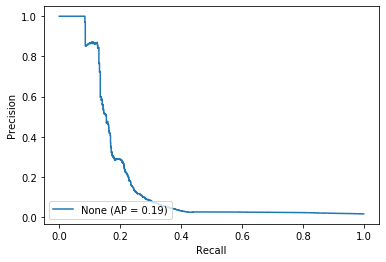

In [19]:
fig = plot_ap(y_test, y_pred_proba)

In [20]:
optimal_threshold, optimal_f1_score = get_optimal_f1_cutoff(y_test, y_pred_proba)
print("F1 Score: ", np.round(optimal_f1_score, 4))

F1 Score:  0.2393


In [21]:
cm = get_confusion_matrix(y_test, y_pred_proba, optimal_threshold)
print("Confusion Matrix: \n", cm)

Confusion Matrix: 
 [[98183   272]
 [ 1298   247]]


In [22]:
from sklearn.metrics import roc_auc_score

In [23]:
roc_auc_score(y_test, y_pred_proba)

0.6832136278972915